In [1]:
import cv2
import numpy as np
import os
from skimage.filters import frangi

# Set constants
NUM_INPUT_FRAMES = 10
NUM_OUTPUT_FRAMES = 20
FRAME_HEIGHT = 256
FRAME_WIDTH = 256
CHANNELS = 1
CROP_BOTTOM = 100  # Number of pixels to crop from the bottom
NUM_CASES_PER_VIDEO = 9  # Number of cases to sample from each video

# Define the width of the middle region
MIDDLE_LEFT = 420   # Adjust this to crop out the black area on the left
MIDDLE_RIGHT = 1500  # Adjust this to crop out the black area on the right

# Adjust contrast and brightness
CONTRAST = 1   # Contrast multiplier (1.0 means no change)
BRIGHTNESS = 0  # Brightness addition (0 means no change)
# Sigmoid adjustment parameters
SIGMOID_STRENGTH = 15  # Controls how sharply values are pushed to 0 or 1
SIGMOID_MIDPOINT = 0.2  # Midpoint where the sigmoid starts pushing values towards 0 or 1

# Folder containing neuron growth videos
video_folder = './Videos_from_Genesis-20241022T191317Z-001'  # Replace with your folder path

def preprocess_frame(frame, global_min, global_max):
    # Crop the bottom part of the frame to remove text
    # cropped_frame = frame[:-CROP_BOTTOM, :, :] if CHANNELS == 3 else frame[:-CROP_BOTTOM, :]
    frame = frame[:-CROP_BOTTOM, MIDDLE_LEFT:MIDDLE_RIGHT, :]

    # Adjust contrast and brightness
    frame = cv2.convertScaleAbs(frame, alpha=CONTRAST, beta=BRIGHTNESS)
    
    # Ensure the frame is in grayscale and uint8 format
    if CHANNELS == 1:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = frame.astype(np.uint8)
    
    # frame = frangi(frame)

    # Sharpening Filter
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]])
    frame = cv2.filter2D(frame, -1, sharpen_kernel)
    
    # Denoising and Smoothing
    frame = cv2.fastNlMeansDenoising(frame, h=10, templateWindowSize=7, searchWindowSize=21)
    frame = cv2.GaussianBlur(frame, (3, 3), 0)

    # Normalize the frame to range [0, 1] based on global min and max
    frame = (frame - global_min) / (global_max - global_min + 1e-8)

    # Sigmoid adjustment to push values toward 0 or 1
    frame = 1 / (1 + np.exp(-SIGMOID_STRENGTH * (frame - SIGMOID_MIDPOINT)))

#     # Step 1: Apply Gaussian blur with two different sigmas for DoG
#     sigma_small = 1
#     sigma_large = 5
#     blur_small = cv2.GaussianBlur(frame, (0, 0), sigma_small)
#     blur_large = cv2.GaussianBlur(frame, (0, 0), sigma_large)
#     dog = blur_small - blur_large

#     # Normalize DoG to 0-255 range for visualization and processing
#     dog_normalized = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

#     # Contrast Stretching
#     p2, p98 = np.percentile(dog_normalized, (2, 90))
#     dog_stretched = cv2.normalize(cv2.inRange(dog_normalized, p2, p98), None, 0, 255, cv2.NORM_MINMAX)


#     # Sharpening Filter
#     sharpen_kernel = np.array([[-1, -1, -1],
#                                 [-1, 9, -1],
#                                 [-1, -1, -1]])
#     blur_large = cv2.filter2D(dog_stretched, -1, sharpen_kernel)

#     # Apply Median Filter to reduce small noise
#     frame = cv2.medianBlur(blur_large, 7)  # Kernel size 5, adjust as needed

    # Resize back to the original dimensions (160x280)
    # frame = cv2.resize(frame, (FRAME_WIDTH * 2, FRAME_HEIGHT * 2))
    # # Resize frame to the target dimensions (160x280), with upsampling or downsampling as needed
    # frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT), interpolation=cv2.INTER_LINEAR if frame.shape[:2] < (FRAME_HEIGHT, FRAME_WIDTH) else cv2.INTER_AREA)

    return frame

# Helper function to sample frames and divide into non-overlapping cases that span the entire video sequence
def sample_frames(video_path, num_cases):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(frame_count)
    # Calculate the number of frames per case
    frames_per_case = frame_count // num_cases

    cases = []  # List to store all cases

    # First pass: Calculate global min and max for normalization
    global_min, global_max = float('inf'), float('-inf')
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        frame_min = frame.min()
        frame_max = frame.max()
        global_min = min(global_min, frame_min)
        global_max = max(global_max, frame_max)

    # Reset the video capture to the beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Second pass: Process each case
    for i in range(num_cases):
        print(f'-- Working on case {i+1}/{num_cases} in {video_path}...')
        
        # Determine start and end indices for each case in terms of frames
        start = i * frames_per_case
        end = (i + 1) * frames_per_case

        # Calculate indices for sampling input and output frames
        input_indices = np.linspace(start, start + frames_per_case // 2, NUM_INPUT_FRAMES, endpoint=False, dtype=int)
        output_indices = np.linspace(start + frames_per_case // 2, end, NUM_OUTPUT_FRAMES, endpoint=False, dtype=int)

        # Read and process the input frames
        X_case = []
        for idx in input_indices:
            # print(f'-- Working on frame {idx}/{frames_per_case} in {num_cases}...')
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            frame = preprocess_frame(frame, global_min, global_max)
            frame = frame[..., np.newaxis]  # Add channel dimension
            X_case.append(frame)

        # Read and process the output frames
        Y_case = []
        for idx in output_indices:
            # print(f'-- Working on frame {idx}/{frames_per_case} in {num_cases}...')
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            frame = preprocess_frame(frame, global_min, global_max)
            frame = frame[..., np.newaxis]  # Add channel dimension
            Y_case.append(frame)

        # Add the case to the list if we got the required number of frames
        if len(X_case) == NUM_INPUT_FRAMES and len(Y_case) == NUM_OUTPUT_FRAMES:
            cases.append((np.array(X_case), np.array(Y_case)))

    cap.release()
    return cases
# Load and process videos, extracting a predetermined number of cases per video
X_data, Y_data = [], []
video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]

for idx, video_name in enumerate(video_files):
    print(f'Processing {round(idx / len(video_files) * 100, 2)}% | {video_name}')
    video_path = os.path.join(video_folder, video_name)
    cases = sample_frames(video_path, num_cases=NUM_CASES_PER_VIDEO)
    
    for X_case, Y_case in cases:
        X_data.append(X_case)
        Y_data.append(Y_case)

# Convert lists to numpy arrays
X_data = np.array(X_data)
Y_data = np.array(Y_data)

# Debugging: Print dimensions of frames in X_data and Y_data
print("X_data shape after splitting:", X_data.shape)  # Expected: (samples, time, channel, frame_height, frame_width)
print("Y_data shape after splitting:", Y_data.shape)  # Expected: (samples, time, channel, frame_height, frame_width)


Processing 0.0% | NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4
-- Working on case 1/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 2/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 3/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 4/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 5/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 6/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 7/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 8/9 in ./Videos_from_Genesis-20241022T191317Z-001/NEURON OUTGROWTH_A8_64_Phase-Overlay.mp4...
-- Working on case 9/9 in ./Videos_fr

In [2]:
# X_data = X_data[:, :, :, :, np.newaxis]  # Add channel dimension
# Y_data = Y_data[:, :, :, :, np.newaxis]  # Add channel dimension
# Y_data = np.squeeze(Y_data, axis=5)
print(X_data.shape)
print(Y_data.shape)

(36, 10, 980, 1080, 1)
(36, 20, 980, 1080, 1)


(980, 1080, 1)


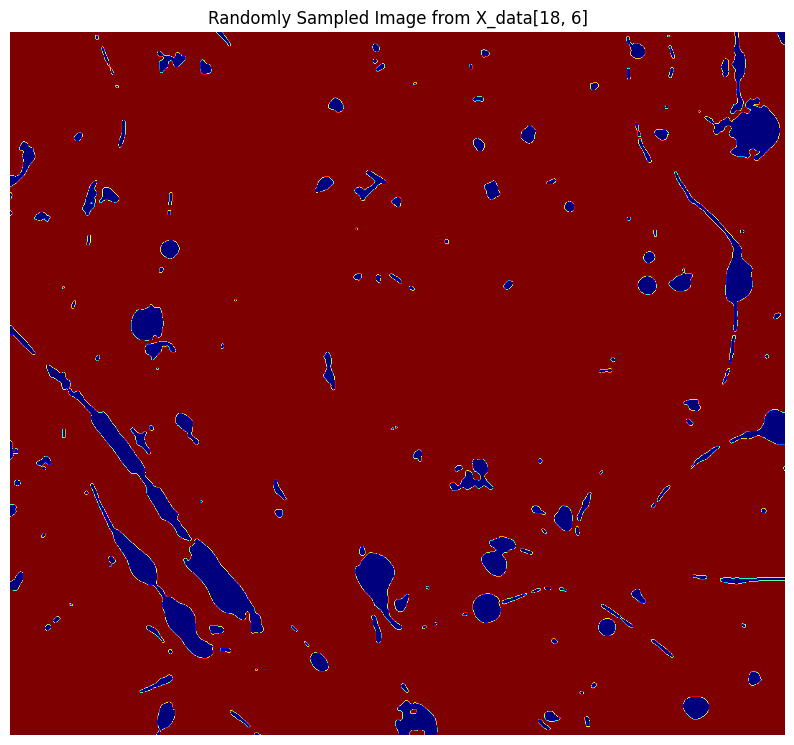

In [3]:
import matplotlib.pyplot as plt

# Function to plot a single image
def plot_image(image, title="Image"):
    """
    Plots a single image.
    :param image: Input image (grayscale or color).
    :param title: Title of the plot.
    """
    # Squeeze any extra channel dimension for grayscale display
    if image.shape[0] == 1:  # If the first dimension is the channel
        image = image.squeeze(0)  # Remove the channel dimension to get shape (160, 280)
    print(image.shape)
    # Plot the image
    plt.figure(figsize=(10, 10))  # Increase the figure size (width, height)
    # plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None, vmin=0, vmax=1)
    # plt.imshow(image, cmap='gray')
    plt.imshow(image, cmap='jet')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage with random sampling
random_sample_index = np.random.randint(0, X_data.shape[0])  # Randomly select a sample from X_data
random_time_step = np.random.randint(0, X_data.shape[1])     # Randomly select a time step for the sample

# Select the random frame
sample_frame = X_data[random_sample_index, random_time_step]  # Select the random sample frame
plot_image(sample_frame, title=f"Randomly Sampled Image from X_data[{random_sample_index}, {random_time_step}]")


In [4]:
print(X_data.shape)

(36, 10, 980, 1080, 1)


In [5]:
# Helper function to split frames into `num_splits x num_splits` sections and resize each to target dimensions
def split_into_sections(data, num_splits):
    # Expect input data shape: (samples, time, row, col, channel)
    input_height, input_width = data.shape[2:4]  # Get row and col from data
    section_height = input_height // num_splits
    section_width = input_width // num_splits

    # List to store all sections across samples
    all_sections = []
    
    for sample in data:
        # Store all time steps for the current sample's sections
        sample_sections = [[] for _ in range(num_splits ** 2)]  # Each sublist for one section across time steps
        
        for frame in sample:  # Loop over each frame in the time sequence
            # Split the frame into `num_splits x num_splits` sections
            sections = []
            for i in range(num_splits):
                for j in range(num_splits):
                    # Extract each section
                    section = frame[i * section_height:(i + 1) * section_height,
                                    j * section_width:(j + 1) * section_width, :]
                    # Resize each section to the target dimensions (target_height, target_width)
                    # print(section)
                    resized_section = cv2.resize(section, (FRAME_WIDTH, FRAME_HEIGHT))
                    # resized_section = cv2.resize(section, (256, 256))
                    # resized_section = section
                    # resized_section = section
                    # Reorder dimensions to (channel, row, col) if required
                    if len(resized_section.shape) == 2:  # If grayscale, add channel dimension
                        resized_section = resized_section[:, :, np.newaxis]
                    resized_section = resized_section.transpose(2, 0, 1)  # (channel, row, col)
                    
                    sections.append(resized_section)
            
            # Append each section for the current time step to the corresponding sample section list
            for k, section in enumerate(sections):
                sample_sections[k].append(section)
        
        # Convert each section's time steps into a numpy array with shape (time, channel, target_height, target_width)
        for section in sample_sections:
            all_sections.append(np.array(section))  # Shape: (time, channel, target_height, target_width)
    
    # Stack all sections into a single array to expand the sample size by `num_splits ** 2`
    return np.array(all_sections)

# Apply split_into_sections to X_data and Y_data
num_splits = 4  # Adjust this value to control the number of splits
X_data_split = split_into_sections(X_data, num_splits)
Y_data_split = split_into_sections(Y_data, num_splits)

print("X_data shape after splitting:", X_data_split.shape)  # Expected: (samples * num_splits^2, time, channel, section_height, section_width)
print("Y_data shape after splitting:", Y_data_split.shape)  # Expected: (samples * num_splits^2, time, channel, section_height, section_width)


X_data shape after splitting: (576, 10, 1, 256, 256)
Y_data shape after splitting: (576, 20, 1, 256, 256)


(256, 256)


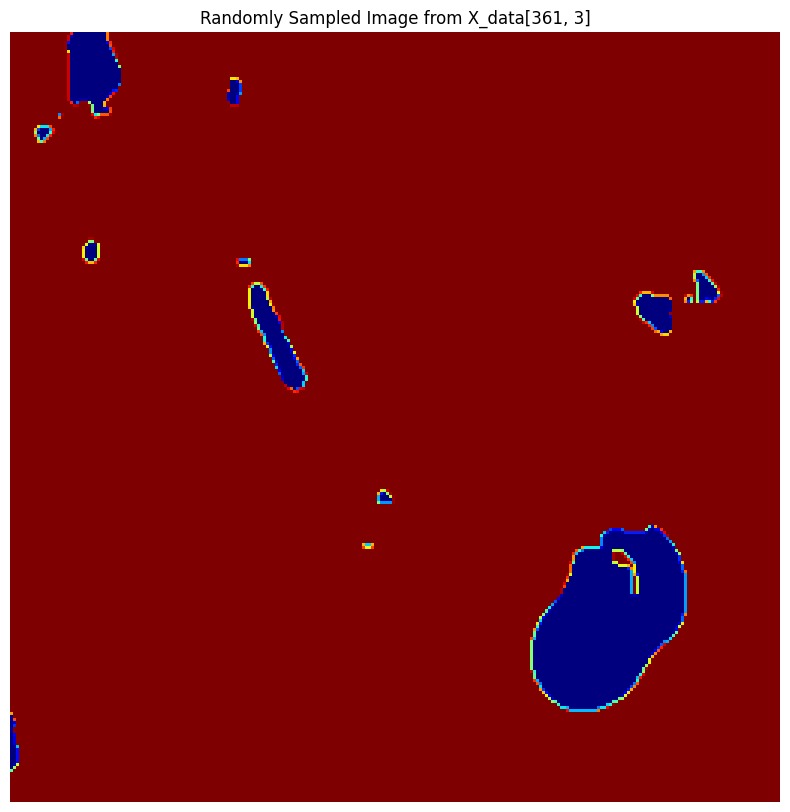

In [6]:
# Example usage with random sampling
random_sample_index = np.random.randint(0, X_data_split.shape[0])  # Randomly select a sample from X_data
random_time_step = np.random.randint(0, X_data_split.shape[1])     # Randomly select a time step for the sample

# Select the random frame
sample_frame = X_data_split[random_sample_index, random_time_step]  # Select the random sample frame
plot_image(sample_frame, title=f"Randomly Sampled Image from X_data[{random_sample_index}, {random_time_step}]")


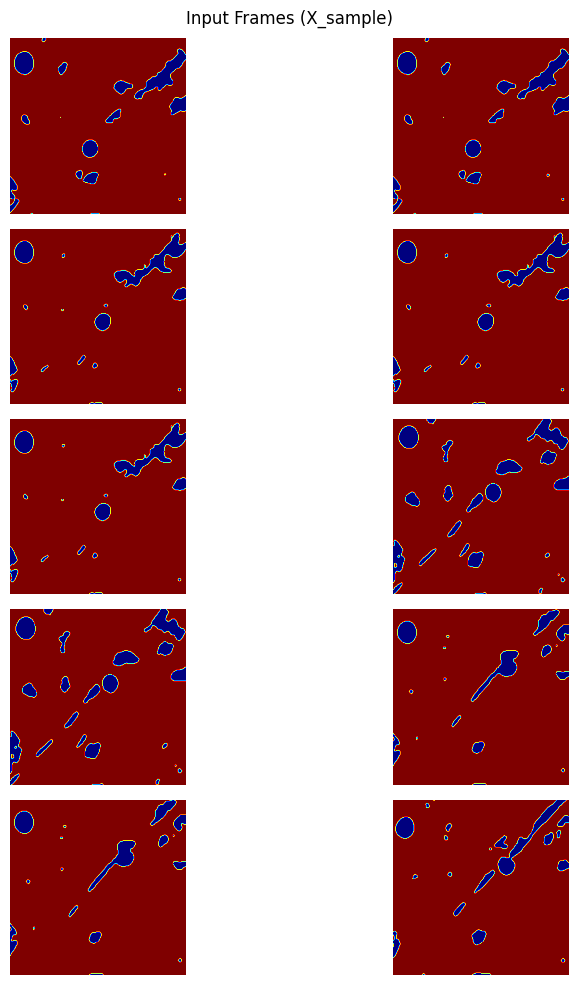

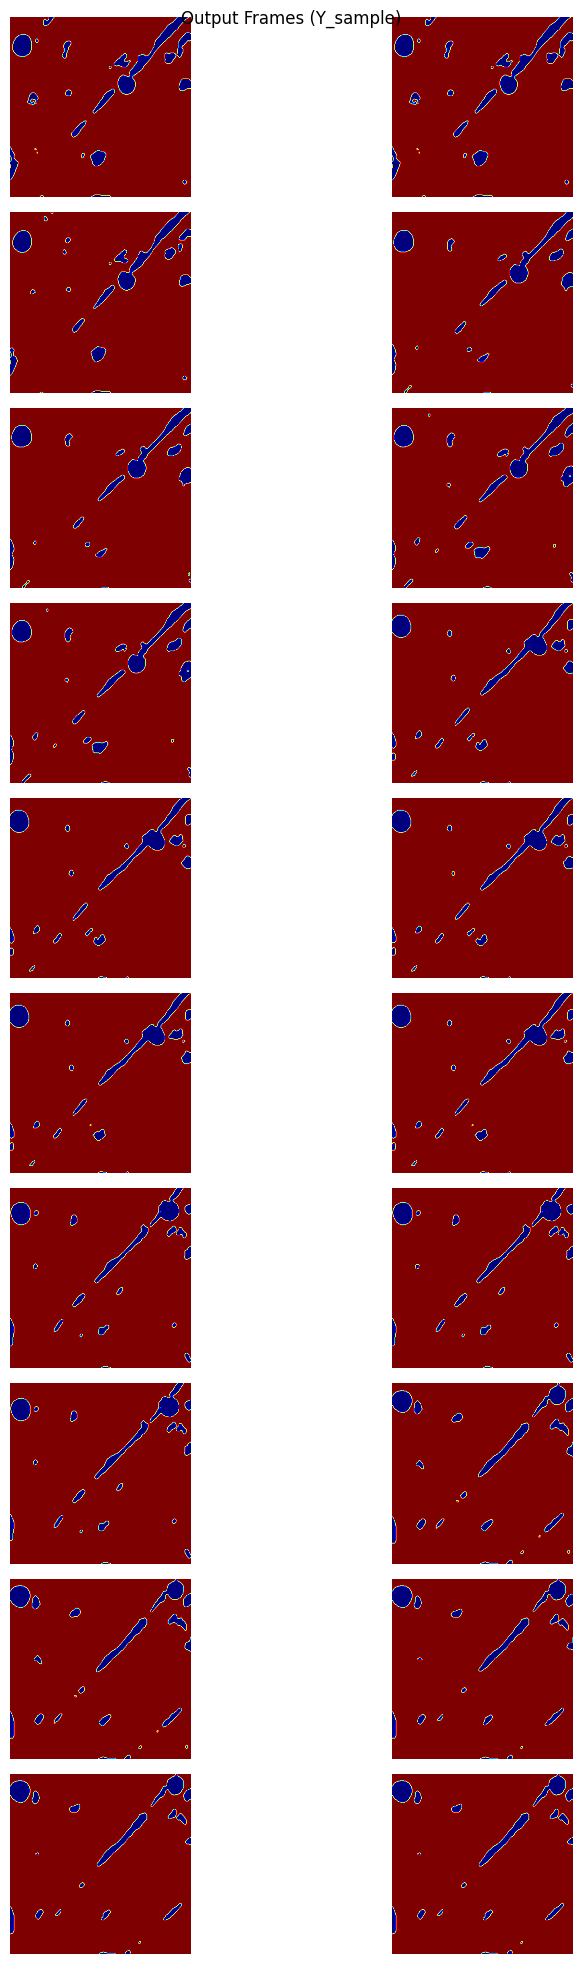

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Randomly select an index for the sample case
random_index = random.randint(0, len(X_data_split) - 1)

# Retrieve the input and output frames for the sampled case
X_sample = X_data_split[random_index]  # Shape: (10, 160, 280, 1)
Y_sample = Y_data_split[random_index]  # Shape: (20, 160, 280, 1)

# Plotting function for the frames in a 2-column layout
def plot_frames_2col(frames, title):
    num_frames = frames.shape[0]
    cols = 2
    rows = (num_frames + 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 2))
    fig.suptitle(title)

    # Plot each frame
    for i in range(num_frames):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        # print(frames.shape)
        # ax.imshow(frames[i, 0, :, :], cmap='gray')
        ax.imshow(frames[i, 0, :, :], cmap='jet')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

# Plot input frames (10 frames in 2 columns)
plot_frames_2col(X_sample, title="Input Frames (X_sample)")

# Plot output frames (20 frames in 2 columns)
plot_frames_2col(Y_sample, title="Output Frames (Y_sample)")


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
print("Splitting data into train, validation, and test sets...")
X_train, X_temp, Y_train, Y_temp = train_test_split(X_data_split, Y_data_split, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Print final shapes to confirm
print("Data split complete.")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


Splitting data into train, validation, and test sets...
Data split complete.
X_train shape: (403, 10, 1, 256, 256)
Y_train shape: (403, 20, 1, 256, 256)
X_val shape: (86, 10, 1, 256, 256)
Y_val shape: (86, 20, 1, 256, 256)
X_test shape: (87, 10, 1, 256, 256)
Y_test shape: (87, 20, 1, 256, 256)


In [9]:
import pickle

# Assuming X_train, Y_train, X_val, Y_val, X_test, and Y_test are already defined
# Reformat the dataset into a dictionary
dataset = {
    'X_train': X_train,
    'Y_train': Y_train,
    'X_val': X_val,
    'Y_val': Y_val,
    'X_test': X_test,
    'Y_test': Y_test
}

# Save the dataset to a .pkl file using pickle
with open(f'./reformatedNDDs/dataset_exp_sep_{NUM_CASES_PER_VIDEO}_split_{num_splits}_input_{NUM_INPUT_FRAMES}_output_{NUM_OUTPUT_FRAMES}_bl.pkl', 'wb') as f:
    pickle.dump(dataset, f)

print(f'./reformatedNDDs/dataset_exp_sep_{NUM_CASES_PER_VIDEO}_split_{num_splits}_input_{NUM_INPUT_FRAMES}_output_{NUM_OUTPUT_FRAMES}_bl.pkl')


./reformatedNDDs/dataset_exp_sep_9_split_4_input_10_output_20_bl.pkl


In [28]:
!nvidia-smi

Sun Nov 24 18:58:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   46C    P0            222W /  300W |   13174MiB /  16384MiB |     99%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
import os
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

0


In [12]:
import os
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))


CUDA_VISIBLE_DEVICES: 0


In [2]:
python tools/test.py -d mmnist -c configs/mmnist/simvp/SimVP_gSTA.py --ex_name mmnist_simvp_gsta

SyntaxError: invalid syntax (1278588894.py, line 1)